## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-09-30 15:43:53--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178,21K  --.-KB/s    in 0,1s    

2021-09-30 15:43:54 (1,29 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [2]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [7]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

In [8]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [9]:
numerical = ['seniority','time','age','expenses','income','assets','debt','amount','price','default']
categorical = ['home','marital','records','job']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

#del df_train['default']
#del df_val['default']
#del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [12]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [13]:
roc_auc_score(df.default, df.seniority)

0.30333545155502395

In [14]:
for numf in numerical:
    score = roc_auc_score(df_train['default'], df_train[numf])
    
    if score < 0.5:
        score = roc_auc_score(df_train['default'], -df_train[numf])
        
    print('%s %.3f' % (numf, score))    

seniority 0.709
time 0.561
age 0.573
expenses 0.501
income 0.682
assets 0.649
debt 0.505
amount 0.591
price 0.504
default 1.000


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

<b>Q1 ANSWER:seniority</b>

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [15]:
del df_train['default']
del df_val['default']

featuresCols = ['seniority', 'income', 'assets', 'records', 'job', 'home']

df_train = df_train[featuresCols]
df_train.head()

,seniority,income,assets,records,job,home
0,12,102,0,no,fixed,private
1,4,143,0,no,fixed,other
2,0,295,6000,no,fixed,owner
3,6,114,3500,no,fixed,owner
4,12,0,15000,no,freelance,owner


In [16]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [17]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[featuresCols].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [18]:
val_dicts = df_val[featuresCols].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred).round(3)
auc

0.811

<b>Q2 ANSWER: 0.812</b>

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [20]:
thresholds = np.arange(0.0, 1.01, 0.01)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
        
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    #scores.append((t, tp, fp, fn, tn))
    scores.append((t, precision, recall))


/tmp/ipykernel_3003/3746749119.py:18: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


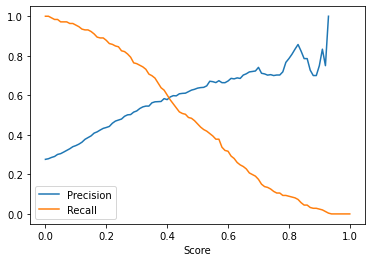

In [21]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')

plt.xlabel('Thresholds')
plt.xlabel('Score')

plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

<b>Q3 ANSWER: 0.4</b>

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [22]:
thresholds = np.arange(0.0, 1.01, 0.01)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
        
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = (2 * ((precision * recall) / (precision + recall))).round(2)
    
    #scores.append((t, tp, fp, fn, tn))
    scores.append((t, F1))

/tmp/ipykernel_3003/2177321066.py:18: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


In [23]:
columnsF1 = ['threshold', 'F1']
df_scoresF1 = pd.DataFrame(scores, columns=columnsF1)
df_scoresF1[::10]

,threshold,F1
0,0.0,0.43
10,0.1,0.51
20,0.2,0.58
30,0.3,0.62
40,0.4,0.59
50,0.5,0.53
60,0.6,0.43
70,0.7,0.28
80,0.8,0.16
90,0.9,0.05


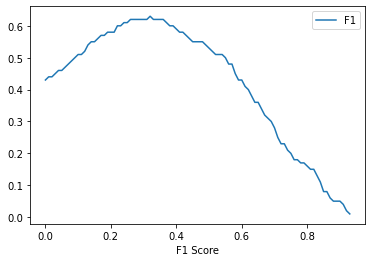

In [24]:
plt.plot(df_scores.threshold, df_scoresF1['F1'], label='F1')

plt.xlabel('Thresholds')
plt.xlabel('F1 Score')

plt.legend()

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

<b>Q4 ANSWER: 0.3</b>

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [29]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [25]:
numerical = ['seniority','time','age','expenses','income','assets','debt','amount','price']
categorical = ['home','marital','records','job']

In [26]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [27]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [34]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [35]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

0.855 +- 0.000
0.859 +- 0.005
0.850 +- 0.015
0.850 +- 0.013
0.844 +- 0.017


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

<b>Q5 ANSWER: 0.014</b>

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [56]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.835 +- 0.018
C=0.1 0.844 +- 0.018
C=1 0.844 +- 0.017
C=10 0.844 +- 0.017


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

<b>Q6 ANSWER: 1</b>

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.